In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import glob
sns.set_style('whitegrid')

import scipy.signal as sigctrl_preproc
import scipy as sp
import os
from preproc_6ax_data import proc_parse_salto_clips_custom, resample_df_clips, load_and_preproc_data_single

#DATA_DIR = '/home/asya/Desktop/Gyro_Data/modeling/'
DATA_DIR = '../Gyro_Data/modeling/'

In [3]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install -q tensorflow==2.3.0
import tensorflow as tf

You should consider upgrading via the '/home/asya/anaconda3/envs/tflite/bin/python -m pip install --upgrade pip' command.


## Preprocess control data 
Clips of data on the silks, and clips off the silks

In [6]:
from preproc_6ax_data import proc_parse_silks_clips_custom, proc_parse_ctrl_clips_custom

## parses out gaps in the data and writes to new files
proc_parse_silks_clips_custom()
proc_parse_ctrl_clips_custom()

In [20]:
a = np.arange(1,1)

In [21]:
a = np.concatenate(([-1, 40], a), axis=0)

In [22]:
a.sort()

In [23]:
a

array([-1, 40])

In [7]:
## Resample the clips to 119 Hz, and rewrite to new folders
resample_df_clips(os.path.join(DATA_DIR,'silks_raw'), interpolation_kind = 'linear', freq_new = 119.)
resample_df_clips(os.path.join(DATA_DIR,'ground_raw'), interpolation_kind = 'linear', freq_new = 119.)

resample_df_clips(os.path.join(DATA_DIR,'silks_raw'), interpolation_kind = 'quadratic', freq_new = 119.)
resample_df_clips(os.path.join(DATA_DIR,'ground_raw'), interpolation_kind = 'quadratic', freq_new = 119.)

ValueError: Expect x to be a 1-D sorted array_like.

## Split data for the model 
split the clips at this point into test, train, validation

clip to particular lengths (maybe better to find a way to do it in the dataloader)

In [ ]:
!python data_split.py -s 50 -combinesalto y -interp linear

In [ ]:
seq_length = 50

**Optional data testing**

In [ ]:
from data_load import DataLoader


def load_data(train_data_path, valid_data_path, test_data_path, seq_length):
  data_loader = DataLoader(
      train_data_path, valid_data_path, test_data_path, seq_length=seq_length)
  data_loader.format()
  return data_loader.train_len, data_loader.train_data, data_loader.valid_len, \
      data_loader.valid_data, data_loader.test_len, data_loader.test_data

train_len, train_data, valid_len, valid_data, test_len, test_data = \
    load_data("../Gyro_Data/test_train_split/train",\
                  "../Gyro_Data/test_train_split/valid",\
                  "../Gyro_Data/test_train_split/test", seq_length)

In [ ]:
print('Train: {}\nValid: {}\nTest:  {}'.format(train_len, valid_len, test_len))

In [ ]:
import json
data = []
label = []
segment_type = 'random'
LABEL_NAME = "movement"
DATA_NAME = "accel_gyro_6ax"

with open("../Gyro_Data/test_train_split/train", "r") as f:
    lines = f.readlines()
    for idx, line in enumerate(lines):  # pylint: disable=unused-variable
        dic = json.loads(line)
        if dic['segment_type'] == segment_type:
            data.append(dic[DATA_NAME])
            label.append(dic[LABEL_NAME])

In [ ]:
variances = []
for idx in range(len(data)):
    var_row = [np.var([a[i] for a in data[idx]]) for i in range(6)]
    variances.append(pd.DataFrame(var_row).T)
variances = pd.concat(variances)

for idx in range(10, len(data)):
    var_row = [np.var([a[i] for a in data[idx]]) for i in range(6)]
    cutoff = (var_row[0] < .5) & (var_row[1] < .5) &(var_row[2] < .5) &\
             (var_row[3] < 5e3) & (var_row[4] < 5e3) &(var_row[5] < 5e3)
    if not cutoff: 
        print(var_row)
        fig, ax = plt.subplots(2,1)
        ax[0].plot(np.asarray([a[0] for a in data[idx]]))
        ax[0].plot(np.asarray([a[1] for a in data[idx]]))
        ax[0].plot(np.asarray([a[2] for a in data[idx]]))
        ax[0].set_ylim([-4,4])        
        ax[1].plot(np.asarray([a[3] for a in data[idx]]))
        ax[1].plot(np.asarray([a[4] for a in data[idx]]))
        ax[1].plot(np.asarray([a[5] for a in data[idx]]))
        ax[1].set_ylim([-400,400])    
        break

In [ ]:
fig, ax = plt.subplots(1,6, figsize = (20,3))
for i in range(6):
    variances[i].hist(bins = 30, ax = ax[i])
    ax[i].set_yscale('log')

## Train and output the model

In [9]:
# Load TensorBoard
%load_ext tensorboard
%tensorboard --logdir logs/scalars

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
/home/asya/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/asya/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/asya/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/asya/anac

# Notes:

145639: seq 100, batch 64, epochs 50, n/epoch 1000 adam(default)

152426: seq 100, batch 64, epochs 500, n/epoch 100 adam(default)

154018: eq 100, batch 64, epochs 50, n/epoch 1000 rmsprop(0.001)

162217: eq 100, batch 64, epochs 50, n/epoch 1000 rmsprop(0.01)

In [10]:
!python train.py --model CNN -s 50 -nout 3

/home/asya/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/asya/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/asya/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/asya/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:5

In [155]:
from train import build_net, load_data, train_model, reshape_function, build_cnn

In [156]:
model, model_path = build_cnn(seq_length)
model.load_weights(os.path.join(model_path,'weights.h5'))

model CNN output categories: 3
sequence length
Built CNN.


In [157]:
_,_,_,_, test_len, test_data = \
        load_data("../Gyro_Data/test_train_split/train",\
                  "../Gyro_Data/test_train_split/valid",\
                  "../Gyro_Data/test_train_split/test", seq_length)

test_data = test_data.map(reshape_function)
test_labels = np.zeros(test_len)
idx = 0
for data, label in test_data:
    test_labels[idx] = label.numpy()
    idx += 1
test_data = test_data.batch(64)

In [158]:
pred = np.argmax(model.predict(test_data), axis=1)

In [159]:
confusion = tf.math.confusion_matrix(
   labels=tf.constant(test_labels),
   predictions=tf.constant(pred),
   num_classes=3)
print(confusion)
#print("Loss {}, Accuracy {}".format(loss, acc))

tf.Tensor(
[[2529   32    2]
 [ 810   33    1]
 [  68    0   62]], shape=(3, 3), dtype=int32)


In [160]:
label2id = {"ground": 0, "silks": 1, "salto_drop": 2, "salto_pike": 3}
label2id = {"ground": 0, "silks": 1, "salto": 2}

list(label2id.keys())

['ground', 'silks', 'salto']

In [161]:
import itertools
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    
    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """
    cm = cm.numpy()
    
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    figure = plt.figure(figsize=(4, 4))
    plt.imshow(cm, cmap=plt.cm.binary)
    plt.title("Model v1 - 1s segments")
    #plt.colorbar()
    plt.grid(visible = False)
    tick_marks = np.arange(4)
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # Normalize the confusion matrix.
    
    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

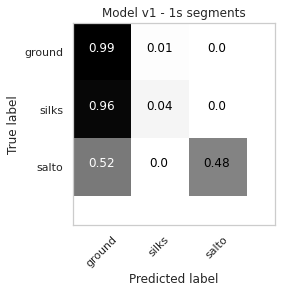

In [162]:
plot_confusion_matrix(confusion,list(label2id.keys()))

In [76]:
label2id = {"ground": 0, "silks": 1, "salto_drop": 2, "salto_pike": 3}
id2label = {v:k for k,v in label2id.items()}

In [77]:
test_decode = [id2label[i] for i in test_labels]
pred_decode = [id2label[i] for i in pred]

In [78]:
#list(zip(test_decode,pred_decode))

In [79]:
# Install xxd if it is not available
!apt-get -qq install xxd

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [80]:
# Save the file as a C source file
!xxd -i model.tflite > ./content/model.cc
# Print the source file
!cat ./content/model.cc

unsigned char model_tflite[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x12, 0x00,
  0x1c, 0x00, 0x04, 0x00, 0x08, 0x00, 0x0c, 0x00, 0x10, 0x00, 0x14, 0x00,
  0x00, 0x00, 0x18, 0x00, 0x12, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x14, 0x00, 0x00, 0x00, 0x28, 0x00, 0x00, 0x00, 0xd0, 0x00, 0x00, 0x00,
  0x28, 0x00, 0x00, 0x00, 0x78, 0x00, 0x00, 0x00, 0x05, 0x00, 0x00, 0x00,
  0xe0, 0x06, 0x00, 0x00, 0x00, 0x06, 0x00, 0x00, 0x7c, 0x03, 0x00, 0x00,
  0xd4, 0x02, 0x00, 0x00, 0xa8, 0x01, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00,
  0xcc, 0x00, 0x00, 0x00, 0x14, 0x00, 0x00, 0x00, 0x10, 0x28, 0x00, 0x00,
  0x0c, 0x28, 0x00, 0x00, 0x04, 0x27, 0x00, 0x00, 0x50, 0x26, 0x00, 0x00,
  0xa8, 0x25, 0x00, 0x00, 0x30, 0x25, 0x00, 0x00, 0xc4, 0x24, 0x00, 0x00,
  0x74, 0x14, 0x00, 0x00, 0x20, 0x13, 0x00, 0x00, 0xc4, 0x0f, 0x00, 0x00,
  0x68, 0x07, 0x00, 0x00, 0xe4, 0x27, 0x00, 0x00, 0xe0, 0x27, 0x00, 0x00,
  0xdc, 0x27, 0x00, 0x00, 0xd8, 0x27, 0x00, 0x00, 0xd4, 0x27, 0x00, 0x00,
  0xd